In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Preprocessing and dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Clustering algorithms
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

# Anomaly detection
from sklearn.ensemble import IsolationForest

# Visualization
from pandas.plotting import parallel_coordinates

In [4]:
# Load the pickle file
trace_data = pd.read_pickle('/Users/linli-shang/Library/CloudStorage/OneDrive-Personal/On_Going/VASSCAA_submission/Paper draft/data copy/trace_data.pkl')

# Normalize the data (if there's no 'Unnamed: 0', directly normalize the entire dataset)
data_normalized = StandardScaler().fit_transform(trace_data)

# Convert back to a DataFrame for further use
normalized_trace_df = pd.DataFrame(data_normalized, columns=trace_data.columns)

# Add a 'Time' column (assuming the index represents the time sequence)
trace_data['Time'] = trace_data.index


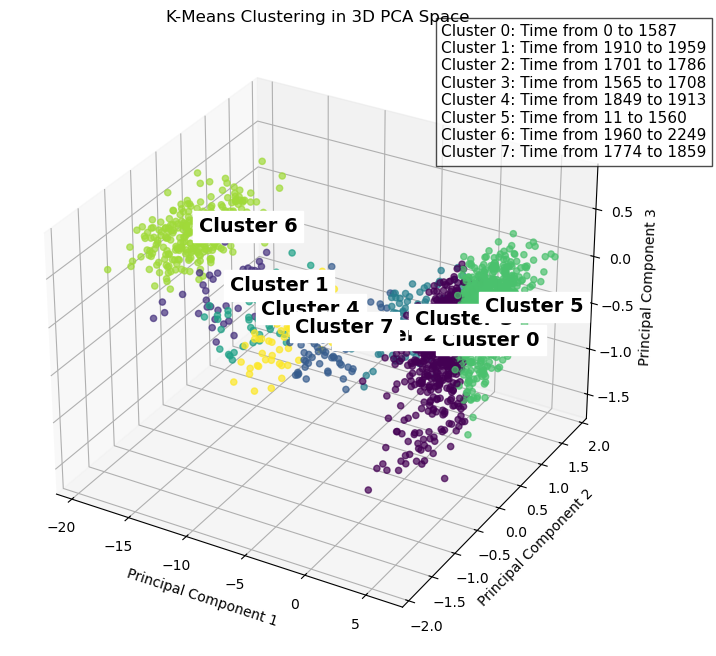

In [12]:
# ----------- PCA Part with 3D Visualization and Cluster Labels ----------------
# Apply PCA to reduce the dimensionality to 3 components for 3D visualization
pca = PCA(n_components=8)
pca_data = pca.fit_transform(normalized_trace_df)

# Apply K-Means clustering with the optimal number of clusters
optimal_clusters = 8  # Based on the elbow method or prior knowledge
kmeans = KMeans(n_clusters=optimal_clusters)
clusters = kmeans.fit_predict(normalized_trace_df)

# Add the clusters back to the trace_data DataFrame
trace_data['Cluster'] = clusters

# Plot the 3D clustering result in the reduced PCA space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=clusters, cmap='viridis', alpha=0.7)

# Add labels for each cluster with improved contrast and font size
for cluster in np.unique(clusters):
    # Get the center point of the cluster for labeling
    cluster_points = pca_data[clusters == cluster]
    center = np.mean(cluster_points, axis=0)
    ax.text(center[0], center[1], center[2], f'Cluster {cluster}', fontsize=14, color='black', fontweight='bold', backgroundcolor='white')

# Add a color bar for the clusters
plt.title("K-Means Clustering in 3D PCA Space")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

# ----------- Time Range for Each Cluster ----------------
# Find the time range for each cluster and print it out
time_ranges = {}
for cluster in np.unique(clusters):
    cluster_times = trace_data[trace_data['Cluster'] == cluster]['Time']
    time_range = (cluster_times.min(), cluster_times.max())
    time_ranges[cluster] = time_range

# Add a text box to display the time ranges for each cluster
time_range_text = "\n".join([f"Cluster {cluster}: Time from {time_ranges[cluster][0]} to {time_ranges[cluster][1]}"
                             for cluster in time_ranges])

# Display the time ranges as an annotation box
plt.annotate(time_range_text, xy=(0.7, 0.9), xycoords='axes fraction', fontsize=11, 
             bbox=dict(facecolor='white', alpha=0.7), verticalalignment='center')

plt.show()

In [13]:
# ----------- Time Range for Each Cluster ----------------
# Find the time range for each cluster and print it out
time_ranges = {}
for cluster in np.unique(clusters):
    cluster_times = trace_data[trace_data['Cluster'] == cluster]['Time']
    time_range = (cluster_times.min(), cluster_times.max())
    time_ranges[cluster] = time_range
    print(f"Cluster {cluster}: Time from {time_range[0]} to {time_range[1]}")

# You can now access time_ranges for each cluster.

Cluster 0: Time from 0 to 1587
Cluster 1: Time from 1910 to 1959
Cluster 2: Time from 1701 to 1786
Cluster 3: Time from 1565 to 1708
Cluster 4: Time from 1849 to 1913
Cluster 5: Time from 11 to 1560
Cluster 6: Time from 1960 to 2249
Cluster 7: Time from 1774 to 1859


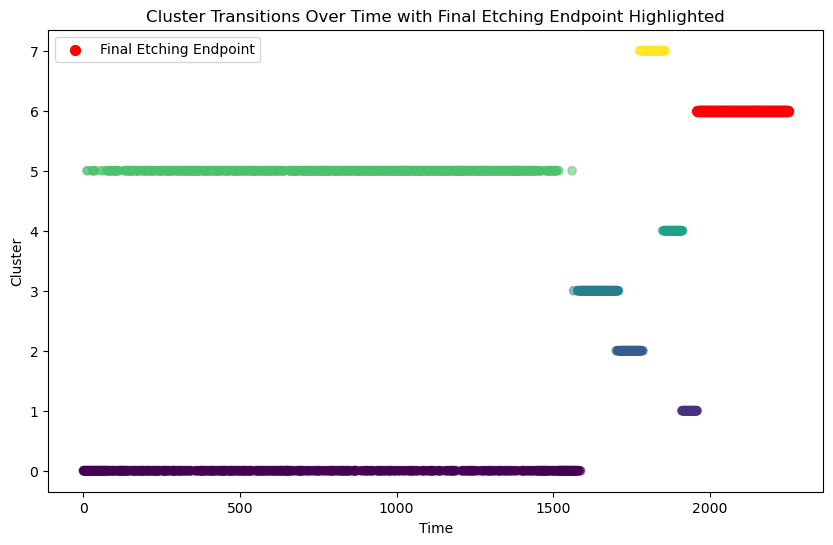

In [14]:
# ----------- Time-Based Cluster Transitions and Final Etching Endpoint ----------------
# Add a 'Time' column (assuming the index represents the time sequence)
trace_data['Time'] = trace_data.index  # Ensure Time column is created from the index
trace_data['Cluster'] = clusters  # Add the cluster information

# Identify the cluster that appears at the end of the process (latest in time)
final_time_points = trace_data['Time'].tail(100)  # Example: Last 100 time points
final_clusters = trace_data.loc[final_time_points.index, 'Cluster']
final_etching_cluster = final_clusters.mode()[0]  # Get the most frequent cluster in the final time points

# Plot to see how the clusters change over time and highlight the final etching endpoint
plt.figure(figsize=(10, 6))
plt.scatter(trace_data['Time'], trace_data['Cluster'], c=trace_data['Cluster'], cmap='viridis', alpha=0.5)
plt.title("Cluster Transitions Over Time with Final Etching Endpoint Highlighted")
plt.xlabel("Time")
plt.ylabel("Cluster")

# Highlight the final etching endpoint cluster
endpoint_times = trace_data[trace_data['Cluster'] == final_etching_cluster]['Time']
plt.scatter(endpoint_times, np.full(len(endpoint_times), final_etching_cluster), color='red', label='Final Etching Endpoint', s=50)

plt.legend()
plt.show()

In [8]:
# ----------- Detect Critical Peaks Automatically ----------------
# Calculate the standard deviation of each peak (column) over time
std_dev = trace_data.std()

# Set a threshold for identifying critical peaks (e.g., peaks with highest variation)
std_threshold = std_dev.mean() + 1.5 * std_dev.std()  # Example: peaks that deviate more than 1.5 std from the mean

# Identify critical peaks as those with standard deviation greater than the threshold
critical_peaks = std_dev[std_dev > std_threshold].index.tolist()

# Output the identified critical peaks
print(f"Automatically Identified Critical Peaks: {critical_peaks}")



Automatically Identified Critical Peaks: [394.6, 404.6, 418.8, 434.2, 450.6, 476.4, 482.8, 507.6]


In [9]:
# ----------- Automatically Select Cluster with Latest Time Range ----------------
# For each cluster, find the max time value and select the cluster with the latest time
latest_cluster = trace_data.groupby('Cluster')['Time'].max().idxmax()

print(f"Automatically selected latest cluster for endpoint detection: Cluster {latest_cluster}")

# ----------- Determine Thresholds Based on the Latest Cluster (98%) ----------------
# We will set the threshold as 98% of the maximum intensity for each critical peak within the latest cluster
latest_cluster_data = trace_data[trace_data['Cluster'] == latest_cluster]  # Select data for the latest cluster

# Calculate stricter thresholds for critical peaks based on the latest cluster's data
peak_thresholds = {}
for peak in critical_peaks:
    peak_max_latest_cluster = latest_cluster_data[peak].max()
    peak_thresholds[peak] = 0.98 * peak_max_latest_cluster  # Set threshold at 98% of the maximum value in the latest cluster

# Output the thresholds for each critical peak
print(f"Stricter Thresholds for Critical Peaks (Based on Cluster {latest_cluster}, 98%): {peak_thresholds}")

Automatically selected latest cluster for endpoint detection: Cluster 1
Stricter Thresholds for Critical Peaks (Based on Cluster 1, 98%): {394.6: 42944.42614, 404.6: 46499.085080000004, 418.8: 36205.09942, 434.2: 55279.07168, 450.6: 28376.20968, 476.4: 40320.80738, 482.8: 29544.93416, 507.6: 21872.52004}


Automatically selected latest cluster for endpoint detection: Cluster 1
Thresholds for Critical Peaks (Based on Earliest Spectra in Cluster 1): {394.6: 43820.843, 404.6: 47448.046, 418.8: 36943.979, 434.2: 56407.216, 450.6: 28883.505, 476.4: 41143.681, 482.8: 30147.892, 507.6: 22318.898}
Final Etching Endpoint Detected at Time: 1904


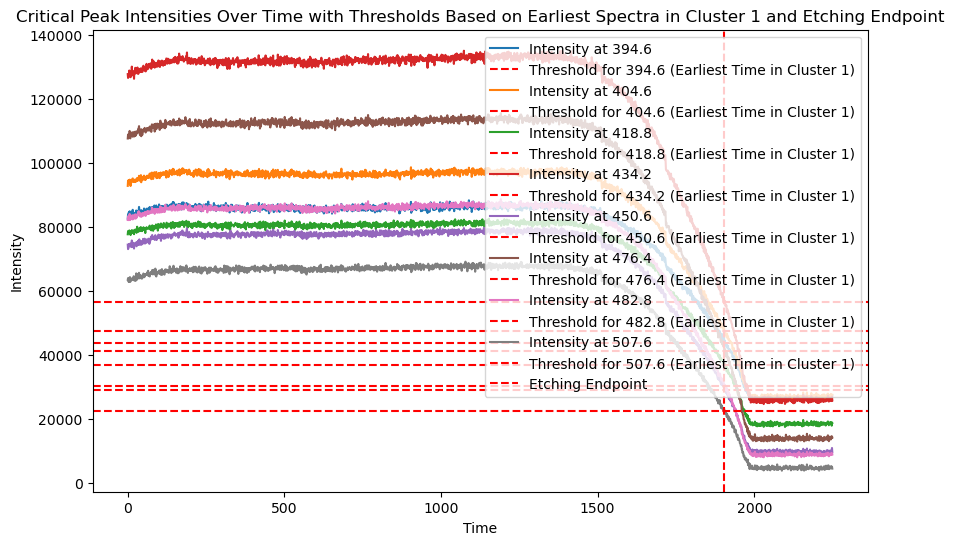

In [10]:


# ----------- Automatically Select Cluster with Latest Time Range ----------------
# For each cluster, find the max time value and select the cluster with the latest time
latest_cluster = trace_data.groupby('Cluster')['Time'].max().idxmax()

print(f"Automatically selected latest cluster for endpoint detection: Cluster {latest_cluster}")

# ----------- Determine Thresholds Based on the Earliest Time Point in the Latest Cluster ----------------
# Select data for the latest cluster
latest_cluster_data = trace_data[trace_data['Cluster'] == latest_cluster]

# Find the earliest time in the latest cluster
earliest_time_latest_cluster = latest_cluster_data['Time'].min()

# Get the spectra data at the earliest time point in the latest cluster
earliest_spectrum = latest_cluster_data[latest_cluster_data['Time'] == earliest_time_latest_cluster]

# Calculate stricter thresholds for critical peaks based on the earliest spectrum's intensity in the latest cluster
peak_thresholds = {}
for peak in critical_peaks:
    earliest_peak_intensity = earliest_spectrum[peak].values[0]  # Intensity at the earliest time in the latest cluster
    peak_thresholds[peak] = earliest_peak_intensity  # Set the threshold as the intensity at the earliest time point

# Output the thresholds for each critical peak
print(f"Thresholds for Critical Peaks (Based on Earliest Spectra in Cluster {latest_cluster}): {peak_thresholds}")

# ----------- Detect the Etching Endpoint Using the Latest Cluster-Based Thresholds ----------------
# Create a boolean condition where all peak intensities must exceed their thresholds
etching_condition = np.ones(len(trace_data), dtype=bool)
for peak, threshold in peak_thresholds.items():
    etching_condition &= trace_data[peak] > threshold  # All peaks must exceed the threshold based on earliest time point

# Assume the etching endpoint happens at the last time period where all critical peaks exceed their thresholds
etching_times = trace_data[etching_condition]['Time']

# Automatically identify the final etching endpoint (last time point that meets the criteria)
if not etching_times.empty:
    final_etching_time = etching_times.iloc[-1]
    print(f"Final Etching Endpoint Detected at Time: {final_etching_time}")
else:
    print("No Etching Endpoint Detected Based on the Current Criteria")

# ----------- Plotting Critical Peaks and Stricter Etching Endpoint ----------------
# Plot intensities of all critical peaks over time and add threshold lines
plt.figure(figsize=(10, 6))
for peak, threshold in peak_thresholds.items():
    plt.plot(trace_data['Time'], trace_data[peak], label=f'Intensity at {peak}')
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold for {peak} (Earliest Time in Cluster {latest_cluster})')

# Plot the final etching endpoint (if detected)
if not etching_times.empty:
    plt.axvline(x=final_etching_time, color='red', linestyle='--', label='Etching Endpoint')

plt.title(f"Critical Peak Intensities Over Time with Thresholds Based on Earliest Spectra in Cluster {latest_cluster} and Etching Endpoint")
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.legend()
plt.show()

In [11]:

trace_data

,348.2,353.2,357.2,361.4,364.8,369.2,370.8,376.2,380.4,381.6,...,656.2,670.4,677.2,678.6,683.6,703.2,777.2,844.4,Time,Cluster
0,5085.200,6566.912,15260.806,13452.162,6102.919,49353.645,9171.103,4861.923,8896.776,39456.803,...,12965.151,27380.699,4051.648,2195.736,5996.557,4923.555,4446.394,1088.259,0,0
1,5180.038,6382.718,15408.781,13713.808,6035.845,49884.456,9037.864,5199.085,8970.664,40149.950,...,12829.529,27808.405,4446.579,2453.259,6458.189,5277.993,4451.384,1076.541,1,0
2,4896.187,6237.283,15151.540,13649.816,6229.529,49881.660,8914.505,5222.308,9157.871,40678.651,...,12685.586,26644.902,4086.592,2211.417,5994.135,4943.666,4242.704,1072.852,2,0
3,4934.703,6292.628,15184.847,13262.228,5801.875,49403.019,9070.566,5128.734,8968.567,40603.103,...,12714.612,26926.442,4089.934,2262.087,6211.870,4929.540,4276.020,1050.334,3,0
4,4969.633,6354.407,15095.029,13478.710,6147.983,50088.939,9219.926,5161.783,9096.400,40341.169,...,12925.426,28059.844,4378.841,2306.020,6153.823,5215.998,4402.511,932.394,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2245,2838.081,3447.779,7650.194,6999.072,3572.840,22964.405,3875.304,2971.171,2869.798,15844.243,...,3220.816,9633.482,2763.699,1757.613,3413.163,1417.284,7867.570,2426.443,2245,1
2246,2761.266,3761.639,8188.962,7412.987,3498.784,22654.838,3592.868,2807.669,2842.901,15767.657,...,3377.324,10510.452,2849.429,1869.278,3946.330,1700.531,7754.106,2497.213,2246,1
2247,2612.099,3527.949,7700.537,7050.047,3367.744,22513.967,3856.560,2737.714,2741.834,15541.071,...,3348.838,9661.855,2541.199,1619.171,3177.714,1170.054,7867.433,2236.898,2247,1
2248,2608.192,3487.029,7611.171,6987.902,3553.414,22557.585,3687.659,2847.201,2911.378,15467.271,...,3592.787,10513.449,2763.936,1897.544,3892.584,1582.143,7907.936,2452.383,2248,1
